# Convert pre-trained models for Inference

How to use:
- Execute cells with `SHIFT + ENTER``
- Make sure to execute cells in order (Executing previous cells might fail). 
- In case you want to reset the environment, use the menu "Kernel", "Restart Kernel and clear all outputs" and restart cells executionfrom the begining

Read more about Tensorflow:
- [Introduction to graphs and tf.function](https://www.tensorflow.org/guide/intro_to_graphs)
- [Save and load models](https://www.tensorflow.org/tutorials/keras/save_and_load)
- [Save and load Keras models](https://www.tensorflow.org/guide/keras/save_and_serialize)
- [Using the SavedModel format](https://www.tensorflow.org/guide/saved_model)
- [Save and load a model using a distribution strategy](https://www.tensorflow.org/tutorials/distribute/save_and_load)
- [TensorFlow Lite converter](https://www.tensorflow.org/lite/convert)
- [Tensorflow Lite Model optimization](https://www.tensorflow.org/lite/performance/model_optimization)

Read more about ONNX:
- [ONNX Runtime documentation](https://www.onnxruntime.ai/docs/)
- [ONNX Github](https://github.com/onnx)
- [keras2onnx - Convert Keras models to ONNX](https://github.com/onnx/keras-onnx)
- [tf2onnx - Convert TensorFlow, Keras and Tflite models to ONNX](https://github.com/onnx/tensorflow-onnx)
- [sklearn-onnx - Convert scikit-learn models to ONN](https://github.com/onnx/sklearn-onnx)
- [Quantization](https://www.onnxruntime.ai/docs/how-to/quantization.html)
- [Performance tuning](https://www.onnxruntime.ai/docs/how-to/tune-performance.html)

Read more about Pytorch:
- [Export Pytorch models to ONNX](https://pytorch.org/docs/stable/onnx.html)

Read more about teh Scaleway AI Inference API:
- [AI Inference API](https://developers.scaleway.com/en/products/inference/api/v1alpha1/)

## Setup

Make sure the environment has the correct versions of the libraries

In [1]:
# Prepare model saving directory
import os
from pathlib import Path

SAVE_DIR = os.path.join(Path('./'), 'saved_models')
if not os.path.isdir(SAVE_DIR):
    os.makedirs(SAVE_DIR)
os.environ["SAVE_DIR"] = SAVE_DIR

## Prepare a model with Pytorch

[Pytorchs Hub](https://pytorch.org/hub/) is a  pre-trained model repository designed for research exploration. In the below example we will use ResNet50.

### Step 1 : Load a pretrained ResNet50 model


In [2]:
import torch
print("Pytorch version {} ".format(torch.__version__))

model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
model.eval() 
print("Model ResNet50 loaded")

Pytorch version 1.8.1+cpu 


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Model ResNet50 loaded


### Step 2 : Make predictions with the model



--2021-03-31 14:37:12--  http://-/
Resolving - (-)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘-’
--2021-03-31 14:37:12--  http://n/
Resolving n (n)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘n’
--2021-03-31 14:37:12--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.2’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.001s  

2021-03-31 14:37:12 (12.5 MB/s) - ‘imagenet_classes.txt.2’ saved [10472/10472]

FINISHED --2021-03-31 14:37:12--
Total wall clock time: 0.2s
Downloaded: 1 files, 10K in 0.001s (12.5 MB/s)
Top 5 pr

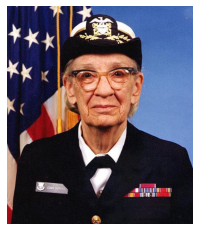

In [3]:
# Download an example image from the pytorch website
import urllib
url, filename =("https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg", "grace_hopper.jpg")

try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)
    
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)

# Add-on : display the image
from matplotlib import pyplot as plt
plt.imshow(input_image)
plt.axis('off')

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
#print(output[0])

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
#print(probabilities) 

# Download ImageNet labels
!wget - N https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
    
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
    
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)

print('Top 5 predictions with the model ResNet50 (pytorch/vision:v0.6.0)')
for i in range(top5_prob.size(0)):
    print("{0:<20s} {1: f}".format(categories[top5_catid[i]], top5_prob[i].item()))
print("\n")
    

### Step 3 : Export the Pytorch model to ONNX format

In [4]:
import torch.onnx
import onnx

FILE_NAME = 'pt-resnet50.onnx'
FILE_PATH = os.path.join(SAVE_DIR, FILE_NAME)

# Export the model
torch.onnx.export(model,                     # model being run
                  input_batch,               # model input (or a tuple for multiple inputs)
                  FILE_PATH,                 # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=9,           # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})



onnx_model = onnx.load(FILE_PATH)
onnx.checker.check_model(onnx_model)

print("Model saved in {}\n".format(FILE_PATH))

Model saved in ./saved_models/pt-resnet50.onnx



Optional : Check predictions done with the ONNX model

In [5]:
# Load the onnx model and make a prediction with the test image

import onnxruntime

# Convert the input image (tensor) to numpy array
x = input_batch.cpu().numpy()

# Do Inference
sess = onnxruntime.InferenceSession(FILE_PATH)
x = x if isinstance(x, list) else [x]
feed = dict([(input.name, x[n]) for n, input in enumerate(sess.get_inputs())])
onnx_pred = sess.run(None, feed)

# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
   
# Show top 5 categories predicted
results = torch.FloatTensor(onnx_pred).squeeze() 
top5_prob, top5_catid = torch.topk(results, 5)

print('Top 5 predictions with the model {} :\n'.format(FILE_PATH))
for i in range(top5_prob.size(0)):
    print("{0:<20s} {1: f}".format(categories[top5_catid[i]], top5_prob[i].item()))


Top 5 predictions with the model ./saved_models/pt-resnet50.onnx :

bow tie               11.704599
suit                  9.684279
Windsor tie           8.481710
military uniform      8.376612
mortarboard           8.143460


## Prepare a model with Tensorflow 2 : Choose and load a pretrained model

Available through the Tensorflow/Keras API, Keras Applications are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning. Find the list of available models at https://keras.io/api/applications/


### Step 1 : Select a model

In [6]:
import importlib

MODELS = ["Xception", "VGG16", "VGG19", "ResNet50", "ResNet101", "ResNet152", "ResNet50V2", "ResNet101V2", "ResNet152V2", "InceptionV3", 
          "InceptionResNetV2", "MobileNet", "MobileNetV2", "DenseNet121", "DenseNet169", "DenseNet201", "NASNetMobile", "NASNetLarge"]

# **************************************************
# ***      You can customize the model choice    ***
# ***                                            ***
# *** Please select a model from the list MODELS ***
#***************************************************
model_choice = "ResNet50"

assert model_choice  in MODELS, "Please choose a model from the MODELS list"

print("You have selected the model: {}\n\n".format(model_choice))


You have selected the model: ResNet50




### Step 2 : Dynamically import the model and its preprocessing function


This step avoids to hard code the imports like for example

```
from tensorflow.keras.applications import ResNet50 as MyModel
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# or
from tensorflow.keras.applications import NASNetLarge as MyModel
from tensorflow.keras.applications.nasnet import preprocess_input, decode_predictions
```

In [7]:
# Dictionary to map models and their preprocessing functions
KERAS_MODELS = {"Xception": "xception", "VGG16": "vgg16", "VGG19": "vgg19", "ResNet50": "resnet", "ResNet101": "resnet", 
                "ResNet152": "resnet", "ResNet50V2": "resnet_v2", "ResNet101V2": "resnet_v2", "ResNet152V2": "resnet_v2", 
                "InceptionV3": "inception_v3", "InceptionResNetV2": "inception_resnet_v2", "MobileNet": "mobilenet", 
                "MobileNetV2": "mobilenet_v2", "DenseNet121": "densenet", "DenseNet169": "densenet", "DenseNet201": "densenet", 
                "NASNetMobile": "nasnet", "NASNetLarge": "nasnet" }

assert model_choice  in KERAS_MODELS.keys(), "Please choose a model whose key is present in the KERAS_MODEL dictionary"


# Helper functions to dynamically import a model and its corresponding preprocessing functions
def import_model(model_choice):

    module = importlib.import_module(f"tensorflow.keras.applications")
    MyModel = getattr(module, model_choice)
    
    module = importlib.import_module(f"tensorflow.keras.applications.{KERAS_MODELS[model_choice]}")
    preprocess_input = getattr(module, f"preprocess_input")
    decode_predictions = getattr(module, f"decode_predictions")
    
    return MyModel, preprocess_input, decode_predictions
    

# Dynamically import the chosen model and its corresponding preprocessing functions
MyModel, preprocess_input, decode_predictions = import_model(model_choice)

print("Model {} is imported\n\n".format(MyModel.__name__))

Model ResNet50 is imported




### Step3 : Build and save the model

In [8]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array

tf.keras.backend.clear_session()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# Load the pre-trained model from Keras Application
model = MyModel(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
)

# Display the model Architecture or number of parameters
#model.summary()
print("Model {0} contains {1: ,d} parameters\n\n".format(model.name, model.count_params()).replace(',', ' '))

# Save the Tensorflow model (not optimized for inference : This is a SavedModel format)
MODEL_NAME = 'tf-' + str(model.name)
FILE_PATH = os.path.join(SAVE_DIR, MODEL_NAME)
model.save(
    filepath=FILE_PATH,
    overwrite=True,
    include_optimizer=False,
    save_format='tf',
    signatures=None,
    options=None,)

print("Model saved to {}\n\n".format(FILE_PATH))

Model resnet50 contains  25 636 712 parameters


Model saved to ./saved_models/tf-resnet50




### Step 4 : Make prediction with the model

Note : At this stage, the model is not optimized for inference (as it can be used to pursue the training or for fine-tuning)

Top 5 predictions with the model resnet50 :

military_uniform      0.987434
bearskin              0.004481
cornet                0.002730
bow_tie               0.001459
pickelhaube           0.000984




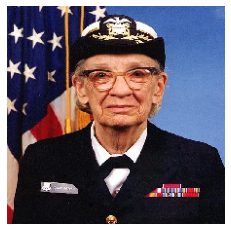

In [9]:
# Get some image examples
file = tf.keras.utils.get_file(
    "grace_hopper.jpg",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg")

# Load  and display the image
img = tf.keras.preprocessing.image.load_img(file, target_size=[224, 224])
plt.imshow(img)
plt.axis('off')

# Preprocess Image to array
x = img_to_array(img)  # This returns a numpy array
x = np.expand_dims(x, axis=0)  # This returns a 4D numpy array (batch = 1)

#  Each Keras Application expects a specific kind of input preprocessing
x = preprocess_input(x) # This returns a numpy array


# Ensure the image is a numpy array (and not a Tensor)
assert isinstance(x, np.ndarray) 

# Do the inference
model.trainable = False
pred = model.predict(x, use_multiprocessing=True)
results = decode_predictions(pred, top=5)[0]
print('Top 5 predictions with the model {} :\n'.format(model.name))
for p in results:
    print("{0:<20s} {1: f}".format(p[1], p[2]))
print("\n")

##  Export the Tensorflow 2 model for inference

### Method 1 : Export the Tensorflow 2 model as a frozen graph, and then convert to ONNX format

See: [LEI MAO'S blogpost ](https://leimao.github.io/blog/Save-Load-Inference-From-TF2-Frozen-Graph/) and associated [GitHub repository](https://github.com/leimao/Frozen-Graph-TensorFlow) (Examples with Tensorflow 1 & 2)



In [10]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Convert Keras model to ConcreteFunction (A ConcreteFunction is a wrapper around a tf.Graph)
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

# Display the layers in the frozen graph
#layers = [op.name for op in frozen_func.graph.get_operations()]
#print("Frozen model layers:")
#for layer in layers:
#    print(layer)

print("Frozen model inputs: {}".format(frozen_func.inputs))
print("Frozen model outputs: {}\n".format(frozen_func.outputs))


# Save frozen graph from frozen ConcreteFunction
MODEL_NAME = str(model.name) 
FILE_NAME = 'tf-' + MODEL_NAME + '-frozen-graph' + '.pb'
FILE_PATH = tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                              logdir=SAVE_DIR,
                              name=FILE_NAME,
                              as_text=False)

print("Model saved to {}\n\n".format(FILE_PATH))

Frozen model inputs: [<tf.Tensor 'x:0' shape=(None, 224, 224, 3) dtype=float32>]
Frozen model outputs: [<tf.Tensor 'Identity:0' shape=(None, 1000) dtype=float32>]

Model saved to ./saved_models/tf-resnet50-frozen-graph.pb




Optional : Check predictions done with the frozen graph

In [11]:
# Load frozen graph using TensorFlow 1.x functions
MODEL_NAME = str(model.name) 
FILE_NAME = 'tf-' + MODEL_NAME + '-frozen-graph' + '.pb'
FILE_PATH = os.path.join(SAVE_DIR, FILE_NAME)
with tf.io.gfile.GFile(FILE_PATH, "rb") as f:
    graph_def = tf.compat.v1.GraphDef()
    loaded = graph_def.ParseFromString(f.read())
# Wrap frozen graph to ConcreteFunctions  
def wrap_frozen_graph(graph_def, inputs, outputs, print_graph=False):
    def _imports_graph_def():
        tf.compat.v1.import_graph_def(graph_def, name="")

    wrapped_import = tf.compat.v1.wrap_function(_imports_graph_def, [])
    import_graph = wrapped_import.graph

    #print("Frozen model layers:")
    #layers = [op.name for op in import_graph.get_operations()]
    #for layer in layers:
    #    print(layer)

    return wrapped_import.prune(
        tf.nest.map_structure(import_graph.as_graph_element, inputs),
        tf.nest.map_structure(import_graph.as_graph_element, outputs))


frozen_func = wrap_frozen_graph(graph_def=graph_def,
                                inputs=["x:0"],
                                outputs=["Identity:0"],
                                print_graph=False)


# Make a prediction with the test image
frozen_graph_predictions = frozen_func(x=tf.constant(x))[0]

pred_2 = frozen_graph_predictions[0].numpy()
if len(pred_2.shape) <2:
    # Add batch dimension as expected by decode_predictions()
    pred_2 = np.expand_dims(pred_2 , axis=0)  
results_2 = decode_predictions(pred_2, top=5)[0]

print('Top 5 predictions with {} :\n'.format(FILE_PATH))
for p in results_2:
    print("{0:<20s} {1: f}".format(p[1], p[2]))
print("\n")

Top 5 predictions with ./saved_models/tf-resnet50-frozen-graph.pb :

military_uniform      0.987434
bearskin              0.004482
cornet                0.002730
bow_tie               0.001459
pickelhaube           0.000984




Converting the frozen graph to ONNX

`tf2onnx` can be used from CLI or API. See [tf2onnx documentation](https://github.com/onnx/tensorflow-onnx)

Example with CLI
```
!python -m tf2onnx.convert --input ./saved_models/tf-resnet50-frozen-graph.pb --output ./saved_models/test.onnx --outputs Identity:0 --inputs x:0
```

Example with API in below cell:

In [12]:
import onnxruntime
import tf2onnx

# Load the frozen graph
FILE_NAME = 'tf-' + MODEL_NAME + '-frozen-graph' + '.pb'
FILE_PATH = os.path.join(SAVE_DIR, FILE_NAME)
with tf.io.gfile.GFile(FILE_PATH, "rb") as f:
    graph_def = tf.compat.v1.GraphDef()
    loaded = graph_def.ParseFromString(f.read())

    
# Convert to ONNX    
FILE_NAME = 'tf-' + MODEL_NAME + '-frozen-graph' + '.onnx'
FILE_PATH = os.path.join(SAVE_DIR, FILE_NAME)

model_proto, external_tensor_storage = tf2onnx.convert.from_graph_def(graph_def,
                name=MODEL_NAME, input_names=['x:0'], output_names=['Identity:0'] , opset=9,
                custom_ops=None, custom_op_handlers=None, custom_rewriter=None, 
                inputs_as_nchw=None, extra_opset=None,
                shape_override=None, target=None, large_model=False,
                output_path=FILE_PATH)

print("Model saved to {}\n\n".format(FILE_PATH))

Model saved to ./saved_models/tf-resnet50-frozen-graph.onnx




Optional : Check predictions done with the ONNX model

In [13]:
# Load the onnx model and make a prediction with the test image

import onnxruntime

MODEL_NAME = str(model.name) 
FILE_NAME = 'tf-' + MODEL_NAME + '-frozen-graph' + '.onnx'
FILE_PATH = os.path.join(SAVE_DIR, FILE_NAME)

sess = onnxruntime.InferenceSession(FILE_PATH)
x = x if isinstance(x, list) else [x]
feed = dict([(input.name, x[n]) for n, input in enumerate(sess.get_inputs())])
onnx_pred = sess.run(None, feed)
results = decode_predictions(onnx_pred[0], top=5)[0]
print('Top 5 predictions with {} :\n'.format(FILE_PATH))
for p in results:
    print("{0:<20s} {1: f}".format(p[1], p[2]))
print("\n")

Top 5 predictions with ./saved_models/tf-resnet50-frozen-graph.onnx :

military_uniform      0.987434
bearskin              0.004481
cornet                0.002730
bow_tie               0.001459
pickelhaube           0.000984




### Method 2 : Export the Tensorflow 2 model to ONNX format (with `keras2onnx`)

See [keras2onnx documentation](https://github.com/onnx/keras-onnx)

In [14]:
import keras2onnx

# Convert model to ONNX
onnx_model = keras2onnx.convert_keras(model, model.name, target_opset=9)

# Save onnx model
FILE_NAME = 'tf-' + MODEL_NAME + '.onnx'
FILE_PATH = os.path.join(SAVE_DIR, FILE_NAME)
keras2onnx.save_model(onnx_model, FILE_PATH)

print("Model saved to {}\n\n".format(FILE_PATH))

tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 458 -> 127


Model saved to ./saved_models/tf-resnet50.onnx




Optional : Check predictions done with the ONNX model

In [15]:
# Load the onnx model and make a prediction with the test image

import onnxruntime

MODEL_NAME = str(model.name) 
FILE_NAME = 'tf-' + MODEL_NAME + '.onnx'
FILE_PATH = os.path.join(SAVE_DIR, FILE_NAME)

sess = onnxruntime.InferenceSession(FILE_PATH)
x = x if isinstance(x, list) else [x]
feed = dict([(input.name, x[n]) for n, input in enumerate(sess.get_inputs())])
onnx_pred = sess.run(None, feed)
results = decode_predictions(onnx_pred[0], top=5)[0]
print('Top 5 predictions with {} :\n'.format(FILE_PATH))
for p in results:
    print("{0:<20s} {1: f}".format(p[1], p[2]))
print("\n")

Top 5 predictions with ./saved_models/tf-resnet50.onnx :

military_uniform      0.987434
bearskin              0.004481
cornet                0.002730
bow_tie               0.001459
pickelhaube           0.000984




### Method 3 : Export the Tensorflow 2 model to TFLight format, and then convert to ONNX format

In [16]:
import tensorflow as tf

# Path to the SavedModel directory
MODEL_NAME = 'tf-' + str(model.name)
FILE_PATH = os.path.join(SAVE_DIR, MODEL_NAME)

# Prepare to convert the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(FILE_PATH) 

# Optional optimisation : Optimize for latency
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY] 

# Optional optimisation : Post-training float16 quantization
converter.target_spec.supported_types = [tf.float16]

# Convert the model to TfLite
tflite_model = converter.convert()

# Save the model
MODEL_NAME = 'tf-' + str(model.name) + '.tflite'
FILE_PATH = os.path.join(SAVE_DIR, MODEL_NAME)

with open(FILE_PATH, 'wb') as f:
    f.write(tflite_model)

print("Model saved to {}\n\n".format(FILE_PATH))

Model saved to ./saved_models/tf-resnet50.tflite




Optional : Check predictions done with the tflite model

In [17]:
# Load the tflite model and make a prediction with the test image

import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors
MODEL_NAME = 'tf-' + str(model.name) + '.tflite'
FILE_PATH = os.path.join(SAVE_DIR, MODEL_NAME)
interpreter = tf.lite.Interpreter(model_path=FILE_PATH)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Makesure the image is a numpy array (and not a python list like for onnx) 
x =np.array(x).reshape((input_details[0]['shape'][0], 
                        input_details[0]['shape'][1], 
                        input_details[0]['shape'][2], 
                        input_details[0]['shape'][3]))

# make a prediction with the test image
interpreter.set_tensor(input_details[0]['index'], x)
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
tflite_pred = interpreter.get_tensor(output_details[0]['index'])

results = decode_predictions(tflite_pred, top=5)[0]
print('Top 5 predictions with {} :\n'.format(FILE_PATH))
for p in results:
    print("{0:<20s} {1: f}".format(p[1], p[2]))
print("\n")

Top 5 predictions with ./saved_models/tf-resnet50.tflite :

military_uniform      0.987512
bearskin              0.004463
cornet                0.002713
bow_tie               0.001424
pickelhaube           0.000983




To convert the tflite model to ONNX, we use the `tf2onnx` CLI as there is currently no helper function in the API to easiliy convert from a tflite model.

See [tf2onnx documentation](https://github.com/onnx/tensorflow-onnx)

In [18]:
import os
from pathlib import Path

# Convert the tflite model to ONNX 
MODEL_NAME = 'tf-' + str(model.name) + '.tflite'
EXPORT_NAME = 'tf-' + str(model.name) + '-tflite.onnx'

os.environ["SOURCE_TFLITE_PATH"] = os.path.join(SAVE_DIR, MODEL_NAME)
os.environ["TARGET_ONNX_MODEL"] = os.path.join(SAVE_DIR, EXPORT_NAME)

# Convert the tflite model to onnx 
!python -m tf2onnx.convert --tflite $SOURCE_TFLITE_PATH --output $TARGET_ONNX_MODEL --opset 9

if Path(os.path.join(SAVE_DIR, EXPORT_NAME)).is_file():
    # file exists
    print("\nModel saved to {}\n\n".format(os.path.join(SAVE_DIR, EXPORT_NAME)))

/root/anaconda/envs/inference/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2021-03-31 14:39:03,965 - INFO - Using tensorflow=2.3.1, onnx=1.8.1, tf2onnx=1.8.4/cd55bf
2021-03-31 14:39:03,965 - INFO - Using opset <onnx, 9>
2021-03-31 14:39:04,359 - INFO - Optimizing ONNX model
2021-03-31 14:39:05,919 - INFO - After optimization: Cast -108 (108->0), Const -3 (111->108), Identity -1 (1->0), Transpose -214 (215->1)
2021-03-31 14:39:06,263 - INFO - 
2021-03-31 14:39:06,264 - INFO - Successfully converted TensorFlow model ./saved_models/tf-resnet50.tflite to ONNX
2021-03-31 14:39:06,264 - INFO - Model inputs: ['input_1']
2021-03-31 14:39:06,264 - INFO - Model outputs: ['Identity']
2021-03-31 14:39:06,264 - INFO - ONNX model is saved at ./saved_models/tf-resnet50-tflite.onnx

Model saved to ./saved_models/tf-

Optional : Check predictions done with the ONNX model:

In [19]:
# Load the onnx model and make a prediction with the test image

import onnxruntime

MODEL_NAME = str(model.name) 
FILE_NAME = 'tf-' + MODEL_NAME + '-tflite.onnx'
FILE_PATH = os.path.join(SAVE_DIR, FILE_NAME)

sess = onnxruntime.InferenceSession(FILE_PATH)
x = x if isinstance(x, list) else [x]
feed = dict([(input.name, x[n]) for n, input in enumerate(sess.get_inputs())])
onnx_pred = sess.run(None, feed)
results = decode_predictions(onnx_pred[0], top=5)[0]
print('Top 5 predictions with {} :\n'.format(FILE_PATH))
for p in results:
    print("{0:<20s} {1: f}".format(p[1], p[2]))
print("\n")

Top 5 predictions with ./saved_models/tf-resnet50-tflite.onnx :

military_uniform      0.987512
bearskin              0.004463
cornet                0.002713
bow_tie               0.001424
pickelhaube           0.000983




Compare the size of the models

In [20]:
%%bash 

printf "Frozen graph, onnx and TfLite models:\n"
ls -lh $SAVE_DIR | grep -v ^d  | cut -d ' ' -f 6,10

printf "\nTensorflow SavedModel repositories:\n"
du -h $SAVE_DIR | cut -d ' ' -f 5

Frozen graph, onnx and TfLite models:

66K iris.onnx
98M pt-resnet50.onnx
98M tf-resnet50-frozen-graph.onnx
98M tf-resnet50-frozen-graph.pb
98M tf-resnet50-tflite.onnx
98M tf-resnet50.onnx
91M tf-resnet50.tar.gz
49M tf-resnet50.tflite

Tensorflow SavedModel repositories:
98M	./saved_models/tf-resnet50/variables
4.0K	./saved_models/tf-resnet50/assets
102M	./saved_models/tf-resnet50
4.0K	./saved_models/.ipynb_checkpoints
729M	./saved_models


## Use the exported models for inference with AI Inference

**IMPORTANT : When decoding the results of the prediction (probabilities) make sure to use the decoding labels corresponding to the model** (For instance resnet50 labels are different with pretrained resnet50 models included in Pytorch or Tensorflow)

### Setup your Scaleway credentials

### Import and Validate the credentials

In [21]:
# Imports
import sys
import os
import json
import requests
import time
import base64
import datetime
from IPython.display import Image
import boto3
from pathlib import Path

In [22]:
# Load credentials through environment variables and setup constants

# Get your credentials at https://console.scaleway.com/project/credentials
# For a new secret key, click on the button [Generate new API Key].
# More information about environment variables for Scaleway at
# https://github.com/scaleway/scaleway-sdk-go/tree/master/scw#environment-variables

environment_variable_keys = [
    "SCW_ACCESS_KEY",
    "SCW_SECRET_KEY",
    "SCW_DEFAULT_ORGANIZATION_ID",
    "SCW_DEFAULT_PROJECT_ID",
    "SCW_DEFAULT_REGION",
    "SCW_DEFAULT_ZONE",
    "SCW_API_URL",
    "SCW_ACCESS_KEY_S3",
    "SCW_SECRET_KEY_S3",
    "S3_BUCKET_NAME"
]

def print_environment_variable(key):
    value = os.getenv(key)
    if key == "SCW_SECRET_KEY" and isinstance(value, str):
        print(f'  ${key}: {value[:4]}...')
    elif key == "SCW_SECRET_KEY_S3" and isinstance(value, str):
        print(f'  ${key}: {value[:4]}...')
    else:
        print(f'  ${key}: {value}')

def assert_environment_variable(key):
    assert os.getenv(key) is not None, f"no value for environment variable ${key}"

def validate_environment_variables(environment_variable_keys):
    print('Validating environment variables')
    for key in environment_variable_keys:
        print_environment_variable(key)
        assert_environment_variable(key)

validate_environment_variables(environment_variable_keys)

# If you prefer not to pass your credentials through environment variables, 
# you can overide the following constants directly.
SCW_SECRET_KEY = os.getenv("SCW_SECRET_KEY")
SCW_ACCESS_KEY = os.getenv("SCW_ACCESS_KEY")
SCW_DEFAULT_ORGANIZATION_ID = os.getenv("SCW_DEFAULT_ORGANIZATION_ID")
SCW_DEFAULT_PROJECT_ID = os.getenv("SCW_DEFAULT_PROJECT_ID")
SCW_DEFAULT_REGION = os.getenv("SCW_DEFAULT_REGION")
SCW_DEFAULT_ZONE = os.getenv("SCW_DEFAULT_ZONE")
SCW_API_URL = os.getenv("SCW_API_URL")

SCW_ACCESS_KEY_S3 = os.getenv("SCW_ACCESS_KEY_S3")
SCW_SECRET_KEY_S3 = os.getenv("SCW_SECRET_KEY_S3")

S3_BUCKET_NAME = os.getenv("S3_BUCKET_NAME")

S3_URL = f"https://s3.{SCW_DEFAULT_REGION}.scw.cloud"
SCW_BUCKET_CONSOLE_BASE_URL = f"https://console.scaleway.com/object-storage/buckets"
SCW_BUCKET_CONSOLE_URL_TEMPLATE = f"{SCW_BUCKET_CONSOLE_BASE_URL}/{SCW_DEFAULT_REGION}/{{bucket_name}}/explorer"

from pathlib import Path
# Prepare model saving directory
SAVE_DIR = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(SAVE_DIR):
    os.makedirs(SAVE_DIR)
os.environ["SAVE_DIR"] = SAVE_DIR


Validating environment variables
  $SCW_ACCESS_KEY: SCW73JGGYVG4AJTR0CCN
  $SCW_SECRET_KEY: dd63...
  $SCW_DEFAULT_ORGANIZATION_ID: 7c304503-a644-4364-9fa1-b75e0de3a5b6
  $SCW_DEFAULT_PROJECT_ID: 7c304503-a644-4364-9fa1-b75e0de3a5b6
  $SCW_DEFAULT_REGION: fr-par
  $SCW_DEFAULT_ZONE: fr-par-1
  $SCW_API_URL: https://api.scaleway.com
  $SCW_ACCESS_KEY_S3: SCW73JGGYVG4AJTR0CCN
  $SCW_SECRET_KEY_S3: dd63...
  $S3_BUCKET_NAME: inference-demo


### Package the Tensorflow models in a `tar.gz`archive and build the list of models to upload in the bucket storage

In the current version, Tensorflow SavedModel models need to be packaged in a 'tar.gz' archive in order to be used with AI Inference.

ONNX models can be used directly with AI Inference

In [23]:
# List the ONNX and Tensorflow models available

import tarfile
import os

MODELS_LIST = []

# Get ONNX models
for file in os.listdir(SAVE_DIR):
    if file.endswith(".onnx"):
        MODELS_LIST.append(file)


# Get Tensorflow SavedModel (directories)
for saved_model in os.listdir(SAVE_DIR):
    if os.path.isdir(os.path.join(SAVE_DIR, saved_model)) and not saved_model.startswith('.'):
        # Tensorflow models must be packaged in a tar.gz archive for AI Inference
        with tarfile.open(os.path.join(SAVE_DIR, saved_model + ".tar.gz"), "w:gz") as tar:
            tar.add(os.path.join(SAVE_DIR, saved_model), arcname=saved_model)
        MODELS_LIST.append(saved_model+'.tar.gz')


print("List of models to upload in the Bucket Storage:\n")
for m in MODELS_LIST:
    print("{}".format(m))
print("\n")

List of models to upload in the Bucket Storage:

pt-resnet50.onnx
tf-resnet50.onnx
iris.onnx
tf-resnet50-tflite.onnx
tf-resnet50-frozen-graph.onnx
tf-resnet50.tar.gz




### Upload the models in a personal Scaleway Object Storage bucket

**Important** : The bucket name must be unique, so you have to customize it.

In [24]:
# Prepare to upload the models in our Scaleway Bucket Storage

import sys
import boto3
from botocore.client import ClientError

def bucket_exists(bucket):
    try:
        resource.meta.client.head_bucket(Bucket=bucket.name)
        return True
    except ClientError:
        return False

def create_bucket_if_not_exist(bucket_name):
    bucket = resource.Bucket(bucket_name)
    if bucket_exists(bucket) == False:
        print(f'creating bucket')
        # The Access policy needs to be public for both Bucket and object
        bucket.create(ACL="public-read")
    else:
        print(f'bucket already exists: {bucket_name}')
    return bucket

def upload_file(bucket, model_path, s3_bucket_filename):
    client = resource.meta.client
    obj_list = client.list_objects(Bucket=bucket.name)
    
    if "Contents" not in obj_list.keys():
        print(f'uploading file: {s3_bucket_filename}')
        with open(model_path, "rb") as model_file:
            bucket.upload_fileobj(model_file, s3_bucket_filename, ExtraArgs={'ACL':'public-read'})
    else:
        obj_key = [ key["Key"] for key in client.list_objects(Bucket=bucket.name)["Contents"] ]
        if s3_bucket_filename not in obj_key:
            print(f'uploading file: {s3_bucket_filename}')
            with open(model_path, "rb") as model_file:
                bucket.upload_fileobj(model_file, s3_bucket_filename, ExtraArgs={'ACL':'public-read'})
        else:
            print(f'file already exists: {s3_bucket_filename}')
    
    return f"{bucket.name}/{s3_bucket_filename}"

s3_session = boto3.Session(region_name=SCW_DEFAULT_REGION)
resource = s3_session.resource(
    "s3",
    endpoint_url=S3_URL,
    aws_access_key_id=SCW_ACCESS_KEY_S3,
    aws_secret_access_key=SCW_SECRET_KEY_S3
)


**Important** : The bucket name must be unique, so you have to customize it.

In [25]:
# Upload the models in our Scaleway Public Bucket Storage

#S3_BUCKET_NAME = f"xxx"  # Customize the bucket name if needed

bucket = create_bucket_if_not_exist(S3_BUCKET_NAME)

MODELS_URLS = []

for FILE in MODELS_LIST:
    FILE_PATH = os.path.join(SAVE_DIR, FILE)
    
    S3_BUCKET_FILENAME = FILE
    s3_model_path = upload_file(bucket, FILE_PATH, S3_BUCKET_FILENAME)

    # Print results
    print(f's3_model_path: {s3_model_path}')
    s3_model_url = f'{S3_URL}/{s3_model_path}'
    MODELS_URLS.append((FILE, s3_model_url))
    print(f's3_model_url: {s3_model_url}')
    print(f'file available at: {SCW_BUCKET_CONSOLE_URL_TEMPLATE.format(bucket_name=bucket.name)}\n')

bucket already exists: inference-demo
file already exists: pt-resnet50.onnx
s3_model_path: inference-demo/pt-resnet50.onnx
s3_model_url: https://s3.fr-par.scw.cloud/inference-demo/pt-resnet50.onnx
file available at: https://console.scaleway.com/object-storage/buckets/fr-par/inference-demo/explorer

file already exists: tf-resnet50.onnx
s3_model_path: inference-demo/tf-resnet50.onnx
s3_model_url: https://s3.fr-par.scw.cloud/inference-demo/tf-resnet50.onnx
file available at: https://console.scaleway.com/object-storage/buckets/fr-par/inference-demo/explorer

file already exists: iris.onnx
s3_model_path: inference-demo/iris.onnx
s3_model_url: https://s3.fr-par.scw.cloud/inference-demo/iris.onnx
file available at: https://console.scaleway.com/object-storage/buckets/fr-par/inference-demo/explorer

file already exists: tf-resnet50-tflite.onnx
s3_model_path: inference-demo/tf-resnet50-tflite.onnx
s3_model_url: https://s3.fr-par.scw.cloud/inference-demo/tf-resnet50-tflite.onnx
file available at

### Make sure the inference API is up

In [26]:
# Make sure the inference API is up

def get_header(secret_key):
    return {
        "Content-Type": "application/json",
        "X-Auth-Token":  secret_key
    }

def api_inference_url(scw_api_url, inference_version):
    return f'{scw_api_url}/inference/{inference_version}'

def get_api_infos(scw_api_url, inference_version, secret_key):
    url = api_inference_url(scw_api_url, inference_version)
    headers = get_header(secret_key)
    response = requests.get(url, headers=headers)
    assert response.status_code == 200
    return response.json()


SCW_INFERENCE_VERSION = "v1alpha1"

print(f'Making sure AI Inference is up')

infos = get_api_infos(SCW_API_URL, SCW_INFERENCE_VERSION, SCW_SECRET_KEY)
print(f'inference api url: {api_inference_url(SCW_API_URL, SCW_INFERENCE_VERSION)}')
print(f'service information: {json.dumps(infos, indent=2)}')

Making sure Inference at Scale is up
inference api url: https://api.scaleway.com/inference/v1alpha1
service information: {
  "name": "Inference",
  "description": "Scaleway Inference At Scale API",
  "version": "1.0.21",
  "documentation_url": "https://developer.scaleway.com/"
}


### Make sure we are nor over quotas

During the Early Access, each users can launch up to 10 model's inference endpoints. 

In the code below, if we are over quotas, you can decide to delete some models

In [27]:
# Make sure we are not over quotas

def get_api_infos(scw_api_url, inference_version, secret_key):
    url = api_inference_url(scw_api_url, inference_version)
    headers = get_header(secret_key)
    response = requests.get(url, headers=headers)
    assert response.status_code == 200
    return response.json()

def model_quotas():
    return 10

def list_models(scw_api_url, inference_version, secret_key, project_id):
    url = f'{scw_api_url}/inference/{inference_version}/models'
    headers = get_header(secret_key)
    payload = {
        "project_id": project_id,
        "page_size": 1000
    }
    response = requests.get(url, headers=headers, params=payload)
    assert response.status_code == 200, f"""can not list models
        status_code: {response.status_code}
        response: {response.json()}"""
    return response.json()['models'], response.json()['total_count']

print(f"getting models")
models, total_count = list_models(
    SCW_API_URL, 
    SCW_INFERENCE_VERSION, 
    SCW_SECRET_KEY,
    SCW_DEFAULT_PROJECT_ID)
print(f"existing models: {total_count}/{model_quotas()}")

for model in models:
    print(f"  {model['id']}: {model['name']}")
    
if total_count >= model_quotas():
    models_to_delete = total_count  - model_quotas()
    print(f"To continue with the demo, you will have to delete {models_to_delete} model.")
    print(f'Set "MODELS_TO_DELETE = {models_to_delete}" in the next cell to do it.')
else:
    print(f"Enough quotas to continue with the demo.")

getting models
existing models: 3/10
  7447e744-366f-4cc2-b44d-93d811c096d9: tf-resnet50.onnx
  b6aec1a4-9f51-4e0a-ae84-be27baef0b3b: pt-resnet50.onnx
  3f3e790c-7652-453c-acb0-3ebd87685ed7: iris.onnx
Enough quotas to continue with the demo.


In [28]:
# Optionally delete models if we are over quotas
MODELS_TO_DELETE = 0  # Number of model to delete

def delete_model(model_id, scw_api_url, inference_version, secret_key):
    print(f'deleting model: {model_id}')
    url = f'{scw_api_url}/inference/{inference_version}/models/{model_id}'
    headers = get_header(secret_key)
    response = requests.delete(url, headers=headers)
    assert response.status_code == 200, f"""can not delete model
        model_id: {model_id}
        status_code: {response.status_code}
        response: {response.json()}"""
    model_info = response.json()
    print(f'status: {model_info["status"]}')
    return model_info

models_deleting_count = min(MODELS_TO_DELETE, len(models))
print(f'models: {total_count}')
print(f'deleting {models_deleting_count} models')
for i in range(models_deleting_count):
    try:
        delete_model(
            models[i]['id'],
            SCW_API_URL,
            SCW_INFERENCE_VERSION,
            SCW_SECRET_KEY)
    except Exception as exception:
        print(exception)

models: 3
deleting 0 models


### Create a Model Inference Endpoint (with the Pytorch-ONNX model)

In [29]:
# Helper functions to create a model and wait for its status to be "ready"

def onnx_model_creation_payload(project_id, s3_model_path, model_name, framework, input_type="float32"):
    # if framework is not defined we try to infer it from the filename/format
    # In the current version of AI Inference Tensorflow models are in 
    # a 'tar.gz' archive while ONNX models are not
    if framework is None:
        if s3_model_path.endswith(".tar.gz"):
            framework="tensorflow:latest"
        else:
            framework="onnx:latest"
    return {
        "project_id": project_id,
        "name": model_name,
        "framework": framework,
        "path": s3_model_path,
        "config": {
            "input_type": input_type
        }
    }

def create_model(scw_api_url, inference_version, secret_key, project_id, s3_model_path, model_name, framework, input_type):
    url = f'{scw_api_url}/inference/{inference_version}/models'
    print(f"creating model at: {url}")
    headers = get_header(secret_key)
    payload = onnx_model_creation_payload(project_id, s3_model_path, model_name, framework, input_type)
    print(f"  payload: {payload}")
    response = requests.post(url, headers=headers, json=payload)
    assert response.status_code == 200, f"""could not create model
        status_code: {response.status_code}
        response: {response.json()}"""
    model = response.json()
    print(f'status: {model["status"]}')
    return model

def get_model(model_id, scw_api_url, inference_version, secret_key):
    url = f'{scw_api_url}/inference/{inference_version}/models/{model_id}'
    # print(f'getting model at: {url}')
    headers = get_header(secret_key)
    response = requests.get(url, headers=headers)
    assert response.status_code == 200, f"""can not get model
        model_id: {model_id}
        status_code: {response.status_code}
        response: {response.json()}"""
    return response.json()

def wait_for_status(
    model_id, expected_status, timeout, retry_interval, 
    scw_api_url, inference_version, secret_key
):
    print(f'waiting for status "{expected_status}"')
    max_retries = int(timeout/retry_interval)
    for retry in range(max_retries):
        model = get_model(model_id, scw_api_url, inference_version, secret_key)
        model_status_lower = model['status'].lower()
        print(f'status: {model_status_lower}')
        if model_status_lower == expected_status.lower():
            return model
        elif model_status_lower == "error":
            print("\nError while deploying the model: {}\n\n".format(model['error_message']))
            return
        else:
            print(f'waiting {retry_interval}s for status "{expected_status}" - {retry+1}/{max_retries}')
            time.sleep(retry_interval)
    raise Exception(f'timeout ({timeout}s) while waiting for status "{expected_status}"')

Select a model for creating an inference endpoint

In [30]:
# Select a model
# In our examples the pytorch model's name start with "pt-"

print("Choose a Pytorch model ID to create an inference endpoint")
for i, m in enumerate(MODELS_URLS):
    if m[0].startswith("pt-"):
        print("ID {} - Model:{}".format(i, m)) 


Choose a Pytorch model ID to create an inference endpoint
ID 0 - Model:('pt-resnet50.onnx', 'https://s3.fr-par.scw.cloud/inference-demo/pt-resnet50.onnx')


In [31]:
# Customize the value  
model_index = 0

print("\nSelected model ID:{}  - Model:{}\n".format(model_index, MODELS_URLS[model_index]))
    


Selected model ID:0  - Model:('pt-resnet50.onnx', 'https://s3.fr-par.scw.cloud/inference-demo/pt-resnet50.onnx')



In [32]:
# Create the model endpoint
READY_MODELS = []
 
m = MODELS_URLS[model_index]

print("\nCreating model inference endpoint for {}".format(m[0]))

model = create_model(
    SCW_API_URL,
    SCW_INFERENCE_VERSION,
    SCW_SECRET_KEY, 
    SCW_DEFAULT_PROJECT_ID, 
    m[1],                  # model url
    m[0],                  # model name
    framework=None,        # framework will be infered from model filename/format
    input_type="float32"   #  input_type   
) 

timeout = 20*60      # 20 minutes
retry_interval = 30  # 30 seconds

ready_model = wait_for_status(
    model['id'], 
    'ready', 
    timeout, 
    retry_interval,
    SCW_API_URL,
    SCW_INFERENCE_VERSION,
    SCW_SECRET_KEY
)
READY_MODELS.append(ready_model)

print(f"model is ready")
print(f"  id:       {ready_model['id']}")
print(f"  name:     {ready_model['name']}")
print(f"  status:   {ready_model['status']}")
print(f"  endpoint: {ready_model['endpoint']}")


Creating model inference endpoint for pt-resnet50.onnx
creating model at: https://api.scaleway.com/inference/v1alpha1/models
  payload: {'project_id': '7c304503-a644-4364-9fa1-b75e0de3a5b6', 'name': 'pt-resnet50.onnx', 'framework': 'onnx:latest', 'path': 'https://s3.fr-par.scw.cloud/inference-demo/pt-resnet50.onnx', 'config': {'input_type': 'float32'}}
status: converting
waiting for status "ready"
status: converting
waiting 30s for status "ready" - 1/40
status: building
waiting 30s for status "ready" - 2/40
status: building
waiting 30s for status "ready" - 3/40
status: building
waiting 30s for status "ready" - 4/40
status: building
waiting 30s for status "ready" - 5/40
status: deploying
waiting 30s for status "ready" - 6/40
status: deploying
waiting 30s for status "ready" - 7/40
status: deploying
waiting 30s for status "ready" - 8/40
status: ready
model is ready
  id:       8a5fa674-1a80-4e59-a8ed-6be792a965c4
  name:     pt-resnet50.onnx
  status:   ready
  endpoint: https://inferenc

### Make a prediction

Note : In this example, the image will be passed as a Binary data format in the Inference request payload.


In [33]:
# Now that our model is deployed and ready, we can finally use it to make a prediction !

def inference_payload(image_filename):
    with open(image_filename, "rb") as image_file:
        return {
            "data": {
                "format": "bin",
                "binData": {
                    "img_mode": "RGB",
                    "img_format": "channels_first",
                    "img_size": [
                        224,
                        224
                    ],
                    "values": base64.b64encode(image_file.read()).decode("utf-8")
                }
            }
        }

def get_predictions(endpoint, filename, verbose=False, raise_on_exception=True):
    if verbose:
        print(f'making inference for "{filename}" at {ready_model["endpoint"]}')
        print(f'this can take a few seconds (if serverless needs to launch endpoints)')
    try:
        inference_results = requests.post(
            endpoint,
            json=inference_payload(filename))
        predictions = json.loads(inference_results.content)['data']['arrayData']['values']
    except Exception as exception:
        if raise_on_exception:
            raise Exception(f"cannot make prediction\n"
                            f"make sure enpoint is up\n"
                            f"endpoint: {endpoint}")
        else:
            print(f"cannot make prediction for {filename} at {endpoint}")
            predictions = []
    return predictions

IMAGE_FILENAME = 'image.png'

inference_results = get_predictions(
    ready_model['endpoint'], 
    IMAGE_FILENAME,
    verbose=True
)
print(f'raw results samples: {inference_results[:5]}')



making inference for "image.png" at https://inferenceatscaleprodbgq4euex-a5fa674-1a80-4e59-a8.functions.fnc.fr-par.scw.cloud
this can take a few seconds (if serverless needs to launch endpoints)
raw results samples: [-4.884707450866699, -2.772667407989502, -3.5425519943237305, -0.03590630367398262, -1.135596752166748]


**Important**: In order to decode the prediction labels we must use the decoding labels corresponding to the model (here provided with Pytorch)

In [34]:
# Now it's time to interpret our results.

# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
    
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)

print('Top 5 predictions with the model ResNet50 (pytorch/vision:v0.6.0)')
for i in range(top5_prob.size(0)):
    print("{0:<20s} {1: f}".format(categories[top5_catid[i]], top5_prob[i].item()))
print("\n")

Top 5 predictions with the model ResNet50 (pytorch/vision:v0.6.0)
bow tie               0.731171
suit                  0.096963
Windsor tie           0.029130
military uniform      0.026224
mortarboard           0.020770




In [35]:
# Make Another prediction (It should be quicker as the serverless endpoints should be still up)

IMAGE_FILENAME = 'grace_hopper.jpg'

inference_results = get_predictions(
    ready_model['endpoint'], 
    IMAGE_FILENAME,
    verbose=True
)
print(f'raw results samples: {inference_results[:5]}')

# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
    
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)

print('\nTop 5 predictions with the model ResNet50 (pytorch/vision:v0.6.0)')
for i in range(top5_prob.size(0)):
    print("{0:<20s} {1: f}".format(categories[top5_catid[i]], top5_prob[i].item()))
print("\n")

making inference for "grace_hopper.jpg" at https://inferenceatscaleprodbgq4euex-a5fa674-1a80-4e59-a8.functions.fnc.fr-par.scw.cloud
this can take a few seconds (if serverless needs to launch endpoints)
raw results samples: [0.6676023006439209, -0.23587651550769806, -0.29037392139434814, 0.3881925344467163, 1.0571587085723877]

Top 5 predictions with the model ResNet50 (pytorch/vision:v0.6.0)
bow tie               0.731171
suit                  0.096963
Windsor tie           0.029130
military uniform      0.026224
mortarboard           0.020770




### Create a Model Inference Endpoint (with the Tensorflow-ONNX model)

In [36]:
# Make sure we are not over quotas

print(f"getting models")
models, total_count = list_models(
    SCW_API_URL, 
    SCW_INFERENCE_VERSION, 
    SCW_SECRET_KEY,
    SCW_DEFAULT_PROJECT_ID)
print(f"existing models: {total_count}/{model_quotas()}")

for model in models:
    print(f"  {model['id']}: {model['name']}")
    
if total_count >= model_quotas():
    models_to_delete = total_count  - model_quotas()
    print(f"To continue with the demo, you will have to delete {models_to_delete} model.")
    print(f'Set "MODELS_TO_DELETE = {models_to_delete}" in the next cell to do it.')
else:
    print(f"Enough quotas to continue with the demo.")

getting models
existing models: 4/10
  8a5fa674-1a80-4e59-a8ed-6be792a965c4: pt-resnet50.onnx
  7447e744-366f-4cc2-b44d-93d811c096d9: tf-resnet50.onnx
  b6aec1a4-9f51-4e0a-ae84-be27baef0b3b: pt-resnet50.onnx
  3f3e790c-7652-453c-acb0-3ebd87685ed7: iris.onnx
Enough quotas to continue with the demo.


In [37]:
# Optionally delete models if we are over quotas
MODELS_TO_DELETE = 0

models_deleting_count = min(MODELS_TO_DELETE, len(models))
print(f'models: {total_count}')
print(f'deleting {models_deleting_count} models')
for i in range(models_deleting_count):
    try:
        delete_model(
            models[i]['id'],
            SCW_API_URL,
            SCW_INFERENCE_VERSION,
            SCW_SECRET_KEY)
    except Exception as exception:
        print(exception)

models: 4
deleting 0 models


In [38]:
# Select a model
# In our examples the tensorflow model's name start with "tf-"

print("Choose a Tensorflow model ID to create an inference endpoint")
for i, m in enumerate(MODELS_URLS):
    if m[0].startswith("tf-"):
        print("ID {} - Model:{}".format(i, m)) 


Choose a Tensorflow model ID to create an inference endpoint
ID 1 - Model:('tf-resnet50.onnx', 'https://s3.fr-par.scw.cloud/inference-demo/tf-resnet50.onnx')
ID 3 - Model:('tf-resnet50-tflite.onnx', 'https://s3.fr-par.scw.cloud/inference-demo/tf-resnet50-tflite.onnx')
ID 4 - Model:('tf-resnet50-frozen-graph.onnx', 'https://s3.fr-par.scw.cloud/inference-demo/tf-resnet50-frozen-graph.onnx')
ID 5 - Model:('tf-resnet50.tar.gz', 'https://s3.fr-par.scw.cloud/inference-demo/tf-resnet50.tar.gz')


In [39]:
# Customize the value  
model_index = 1

print("\nSelected model ID:{}  - Model:{}\n".format(model_index, MODELS_URLS[model_index]))
    


Selected model ID:1  - Model:('tf-resnet50.onnx', 'https://s3.fr-par.scw.cloud/inference-demo/tf-resnet50.onnx')



In [40]:
# Create the model endpoint
 
m = MODELS_URLS[model_index]
   

print("\nCreating model inference endpoint for {}".format(m[0]))

model = create_model(
    SCW_API_URL,
    SCW_INFERENCE_VERSION,
    SCW_SECRET_KEY, 
    SCW_DEFAULT_PROJECT_ID, 
    m[1],                  # model url
    m[0],                  # model name
    framework=None,        # framework will be infered from model filename/format
    input_type="float32"   #  input_type  
)

timeout = 20*60      # 20 minutes
retry_interval = 30  # 30 seconds

ready_model = wait_for_status(
    model['id'], 
    'ready', 
    timeout, 
    retry_interval,
    SCW_API_URL,
    SCW_INFERENCE_VERSION,
    SCW_SECRET_KEY
)
READY_MODELS.append(ready_model)

print(f"model is ready")
print(f"  id:       {ready_model['id']}")
print(f"  name:     {ready_model['name']}")
print(f"  status:   {ready_model['status']}")
print(f"  endpoint: {ready_model['endpoint']}")


Creating model inference endpoint for tf-resnet50.onnx
creating model at: https://api.scaleway.com/inference/v1alpha1/models
  payload: {'project_id': '7c304503-a644-4364-9fa1-b75e0de3a5b6', 'name': 'tf-resnet50.onnx', 'framework': 'onnx:latest', 'path': 'https://s3.fr-par.scw.cloud/inference-demo/tf-resnet50.onnx', 'config': {'input_type': 'float32'}}
status: converting
waiting for status "ready"
status: converting
waiting 30s for status "ready" - 1/40
status: building
waiting 30s for status "ready" - 2/40
status: building
waiting 30s for status "ready" - 3/40
status: building
waiting 30s for status "ready" - 4/40
status: building
waiting 30s for status "ready" - 5/40
status: building
waiting 30s for status "ready" - 6/40
status: deploying
waiting 30s for status "ready" - 7/40
status: deploying
waiting 30s for status "ready" - 8/40
status: deploying
waiting 30s for status "ready" - 9/40
status: deploying
waiting 30s for status "ready" - 10/40
status: deploying
waiting 30s for status 

### Make a Prediction

With our Tensorflow implementation, we should use the ResNet50 preprocessing.

Note : In this example, the pre-processed image will be passed as a data Array format in the Inference request payload.

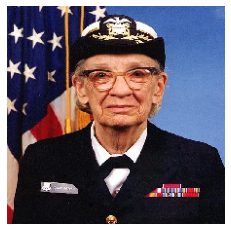

In [41]:
# Preprocess the input image as expected by the Resnet50 model

import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Get image for inference

file = tf.keras.utils.get_file(
    "grace_hopper.jpg",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg")


# Load  and display the image
img = tf.keras.preprocessing.image.load_img(file, target_size=[224, 224])
plt.imshow(img)
plt.axis('off')

# Preprocess Image
x = tf.keras.preprocessing.image.img_to_array(img)
x  = tf.expand_dims(x, axis=0)  # 4D Tensor (batch = 1)


#  Each Keras Application expects a specific kind of input preprocessing.
x = tf.keras.applications.resnet50.preprocess_input(x)

In [42]:
# Now that our model is deployed and ready, we can finally use it to make a prediction !

import json

img = np.array(x)

def inference_payload(img):
    return {
        "data": {
            "format": "array",
            "arrayData": {
              "shape": [1, 224, 224, 3],
              "values": img.tolist()
            }
        }
    }


def get_predictions(endpoint, image_array):
    print(f'making inference with {ready_model["endpoint"]}')
    print(f'this can take a few seconds (if serverless needs to launch endpoints)')
    try:
        inference_results = requests.post(
            ready_model['endpoint'],
            json=inference_payload(image_array))
        predictions = json.loads(inference_results.content)['data']['arrayData']['values']
    except Exception as exception:
        raise Exception(f"cannot make prediction\n"
                        f"make sure enpoint is up\n"
                        f"endpoint: {endpoint}")
        
    return predictions


inference_results = get_predictions(ready_model['endpoint'], np.array(x))

results = decode_predictions(np.expand_dims(np.array(inference_results), axis=0) , top=5)[0]
print('\nTop 5 predictions:')
for p in results:
    print("{0:<20s} {1: f}".format(p[1], p[2]))
print("\n")

making inference with https://inferenceatscaleprodbgq4euex-cf687836-0e6e-4cea-a.functions.fnc.fr-par.scw.cloud
this can take a few seconds (if serverless needs to launch endpoints)

Top 5 predictions:
military_uniform      0.987434
bearskin              0.004482
cornet                0.002730
bow_tie               0.001459
pickelhaube           0.000984




## Debug tools

In [ ]:
%%bash

# List your Inference models deployed in production
curl -s -X GET  -H "X-Auth-Token: $SCW_SECRET_KEY" \
                -G -d "project_id=$SCW_DEFAULT_PROJECT_ID" \
                https://api.scaleway.com/inference/v1alpha1/models | jq '.'